### Schema

0. x coordinate
1. y coordinate
2. timestamp
3. pen-up
4. azimuth angle
5. altitude angle
6. Pressure

In [1]:
import pandas as pd
import numpy as np
from os import path
import sys


#plotting
from matplotlib import pyplot as plt
%matplotlib inline

#processing
from scipy.signal import resample


In [2]:
#ml
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
#import tensorflow_docs as tfdocs
#import tensorflow_docs.modeling
import mlflow
import mlflow.tensorflow


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
features=['x','y','pen_up','pressure']
doc_path = "/data/elekin/doc"

In [4]:
metadf=pd.read_csv(path.join(doc_path,"metadata-202106-v1.csv"),index_col=0)
# metadf[metadf["temblor"]=='si']

In [5]:
# Creating a data structure with subjects time series and tremor levels
 
X = []
y = []

for path, level in zip(metadf.abs_path, metadf.level):
    df = pd.read_csv(path, sep="\s+",header=None,names=features,skiprows=1,usecols=[0,1,3,6])
    X.append(resample(df.values.astype('int16'), 4096))
    y.append(level)

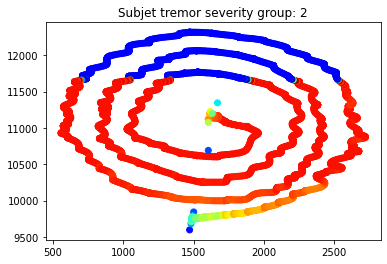

In [6]:
idx = 15
label = y[idx]
plt.scatter(X[idx][:,0], X[idx][:,1], c=X[idx][:,3], cmap='jet')
_=plt.title("Subjet tremor severity group: {}".format(label))

In [7]:
np.array(X).shape

(53, 4096, 4)

In [8]:
seed = 42
n_outputs = 3
mini_batch_size=4

n_timesteps = np.array(X).shape[1]
n_features = np.array(X).shape[2]

data_size = np.array(X).shape[0]
train_split = 0.67
test_split = 0.33
train_size = int(train_split * data_size)
test_size = int(test_split * data_size)

shuffle_buffer = data_size
steps_per_epoch = round(data_size/mini_batch_size)


AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time

URI = "http://mlflow_server:5001"

mlflow.set_tracking_uri(URI)
mlflow.set_experiment('/archimedes-dl')

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((X, tf.one_hot(y,n_outputs)))
full_dataset = dataset.shuffle(shuffle_buffer, seed=seed)
train_dataset = full_dataset.take(train_size).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = full_dataset.skip(train_size).batch(mini_batch_size).prefetch(AUTOTUNE).cache()

# for feat, targ in train_dataset.shuffle(shuffle_buffer):
# #         print ('Features: {0}'.format(feat, targ))
#     print ('Target train: {1}'.format(feat, targ))
    
# for feat, targ in test_dataset.shuffle(shuffle_buffer):
# #         print ('Features test: {}, Target test: {}'.format(feat, targ))
#         print ('Target test: {1}'.format(feat, targ))

# print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
#                                                                               len(test_dataset),
#                                                                               mini_batch_size,
#                                                                                 steps_per_epoch))

In [10]:
# #Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=1e-3,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=1e-4,
  patience=200)

def get_callbacks(name):
    return [
        #tfdocs.modeling.EpochDots(),
        earlystop_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2e2, min_delta=1e-5),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1e3):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=0, shuffle=True)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1e3):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [11]:
size_histories = {}
run = 'lstm/tiny'
mlflow.tensorflow.autolog(every_n_iter=1)
do = 0.20
units = 128

mlflow.start_run(run_name=run)
mlflow.log_param("seed", seed)
mlflow.log_param("drop_out", do)
mlflow.log_param("mini_batch_size", mini_batch_size)
mlflow.log_param("train_split", train_split)
mlflow.log_param("test_split", test_split)
mlflow.log_param("lstm_units", units)
mlflow.log_param("features", features)

2022/08/25 00:19:39 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units, activation=tf.nn.tanh, return_sequences=True, input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.LSTM(units, activation=tf.nn.tanh, return_sequences=True ))
model.add(tf.keras.layers.Dropout(do))
model.add(tf.keras.layers.LSTM(units, activation=tf.nn.tanh, return_sequences=False ))
model.add(tf.keras.layers.Dropout(do))
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu, name='hidden_layer'))
model.add(tf.keras.layers.Dense(n_outputs, activation=tf.nn.sigmoid, name='output'))

In [ ]:
size_histories[run] = compile_and_fit(model, train_dataset, test_dataset,
                                              run, 
                                              optimizer=get_optimizer(),
#                                               optimizer=tf.keras.optimizers.Adam(0.001), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=1000)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories[run].history["accuracy"]))
print('test acc:', max(size_histories[run].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4096, 128)         68096     
                                                                 
 lstm_1 (LSTM)               (None, 4096, 128)         131584    
                                                                 
 dropout (Dropout)           (None, 4096, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 hidden_layer (Dense)        (None, 100)               12900     
                                                                 
 output (Dense)              (None, 3)                 3

In [ ]:
mlflow.end_run()